<a href="https://colab.research.google.com/github/anosharahim/cs156-final-project/blob/main/doodle-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.7.0'

In [2]:
# import necessary libraries
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib, xml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from google.colab import drive

In [3]:
#mount at gdrive
data_path = '/content/gdrive/My Drive/amld_data'
drive.mount('/content/gdrive')

#assert data_path.startswith('/content/gdrive/My Drive/'), 'Google Drive paths must start with "/content/gdrive/My Drive/"!'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
#Retrieve List of Categories 

def list_bucket(bucket, regexp='.*'):
    """Returns a filtered list of Keys in specified GCS bucket."""
    keys = []
    fh = urllib.request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = xml.dom.minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

def valid_ndjson(filename):
  """Checks presence + completeness of .ndjson file."""
  try:
    json.loads(tf.io.gfile.GFile(filename).readlines()[-1])
    return True
  except (ValueError, IOError):
    return False

def retrieve(bucket, key, filename):
  """Returns a file specified by its Key from a GCS bucket."""
  url = 'https://storage.googleapis.com/%s/%s' % (
    bucket, urllib.parse.quote(key))
  print('\n' + url)
  if not tf.io.gfile.exists(filename):
    with tf.io.gfile.GFile(filename, 'w') as f:
      f.write(urllib.request.urlopen(url).read())
  while not valid_ndjson(filename):
    print('*** Corrupted download (%.2f MB), retrying...' % (
        os.path.getsize(filename) / 2.**20))
    with tf.io.gfile.GFile(filename, 'w') as f:
      f.write(urllib.request.urlopen(url).read())

In [23]:
all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')

#select only animal categories from the Quick, Draw! dataset
pets = ['cat', 'dog']
zoo = ['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe',
       'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat',
           'cow', 'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck',
           'elephant', 'fish', 'flamingo', 'frog', 'giraffe', 'hedgehog',
           'horse', 'kangaroo', 'lion', 'lobster', 'monkey', 'mosquito',
           'mouse', 'octopus', 'owl', 'panda', 'parrot', 'penguin', 'pig',
           'rabbit', 'raccoon', 'rhinoceros', 'scorpion', 'sea turtle', 'shark',
           'sheep', 'snail', 'snake', 'spider', 'squirrel', 'swan']

labels, dataset_name = pets, 'pets' #select categories 

### Get files for selected categories ###
tf.io.gfile.makedirs(data_path)
print('\n%d labels:' % len(labels))

for name in labels:
  print(name, end=' ')
  dst = '%s/%s.ndjson' % (data_path, name)
  retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
  print('%.2f MB' % (tf.io.gfile.stat(dst).length / 2.**20))

print('\nDONE :)')


2 labels:
cat 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/cat.ndjson
73.12 MB
dog 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/dog.ndjson
87.06 MB

DONE :)


-------------- Meta Information for One Drawing ---------------
                word   ->   ant
         countrycode   ->   US
           timestamp   ->   2017-03-27 00:14:57.31033 UTC
          recognized   ->   True
              key_id   ->   5421013154136064
Shapes: [(2, 10), (2, 2), (2, 3), (2, 15), (2, 2), (2, 15), (2, 2), (2, 2), (2, 2), (2, 3), (2, 3)]
Example stroke: [[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [47, 58, 73, 81, 84, 67, 54, 46, 47, 51]]


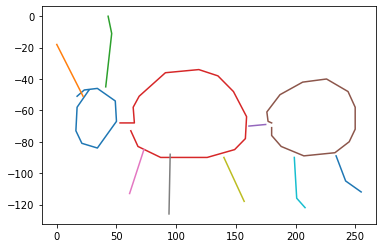

In [24]:
### Inspect a Drawing ### 

path = sorted(tf.io.gfile.glob(os.path.join(data_path, '*.ndjson')))[0]

#view meta information about drawing 
print('-------------- Meta Information for One Drawing ---------------')
for k, v in data_json.items():
  if k != 'drawing':
    print('%20s   ->   %s' % (k, v))

# Extract the actual drawing from json
drawing = data_json['drawing']

# The drawing consists of a series of strokes:
print('Shapes:', [np.array(stroke).shape for stroke in drawing]) #stroke shapes
print('Example stroke:', drawing[0]) #stroke info

# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:
for stroke in drawing:
  # Each array has X coordinates at [0, :] and Y coordinates at [1, :].
  plt.plot(np.array(stroke[0]), -np.array(stroke[1]))

Loading 100 instances of "cat"...done.


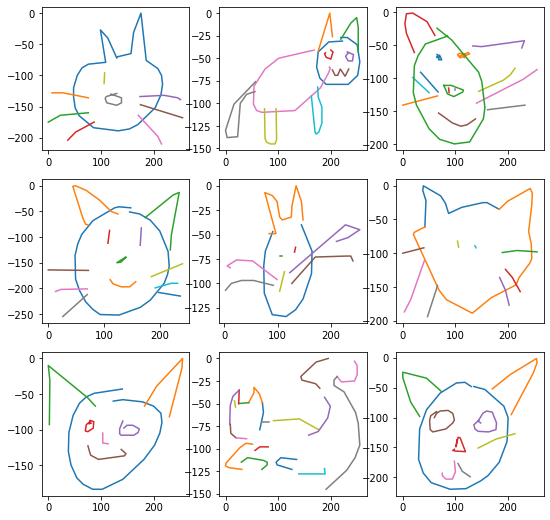

In [27]:
### Load many sketches at once ### 

def convert(line):
  """Converts single JSON line and converts 'drawing' to list of np.array."""
  d = json.loads(line)
  d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
  return d

def loaditer(name, unrecognized=False):
  """Returns iterable of drawings in specified file.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  for line in tf.io.gfile.GFile('%s/%s.ndjson' % (data_path, name)):
    d = convert(line)  
    if d['recognized'] or unrecognized:
      yield d

def loadn(name, n, unrecognized=False):
  """Returns list of drawings.
  
  Args:
    name: Name of the downloaded object (e.g. "elephant").
    n: Number of drawings to load.
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  it = loaditer(name, unrecognized=unrecognized)
  return list(itertools.islice(it, 0, n))


n = 100 
print('Loading {} instances of "{}"...'.format(n, labels[0]), end='')
sample = loadn(labels[0], 100)
print('done.')

#Visualize drawings.
rows, cols = 3, 3
plt.figure(figsize=(3*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    plt.subplot(rows, cols, i + 1)
    for stroke in sample[i]['drawing']:
      plt.plot(np.array(stroke[0]), -np.array(stroke[1]))